In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

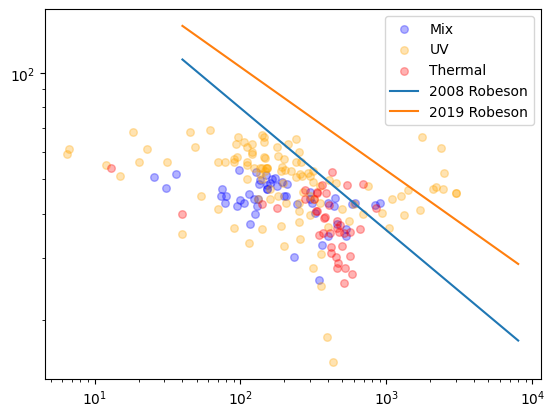

In [2]:
# visualize data
dfs = [
    pd.read_excel('data/mix.xlsx', header=0),
    pd.read_excel('data/uv.xlsx', header=0),
    pd.read_excel('data/th.xlsx', header=0),
]
labels = ['Mix', 'UV', 'Thermal']
colors = ['blue', 'orange', 'red']
for df, l, c in zip(dfs, labels, colors):
    plt.scatter(df['Permeability'], df['Selectivity'], c=c, alpha=0.3, s=30, label=l)

xs = [40, 8000]
ys_2008 = [30.967e6**(1/2.888)*x**(-1/2.888) for x in xs]
ys_2019 = [755.58e6**(1/3.409)*x**(-1/3.409) for x in xs]
plt.plot(xs, ys_2008, label='2008 Robeson')
plt.plot(xs, ys_2019, label='2019 Robeson')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [3]:
# define dictionary: molecules -> fragments
# format: [{terminal group SMILES: num.}, {non-terminal group SMILES: num.}]
polymer_dict = {
    'Pebax 1657': [{'[NH2]': 2}, {'CCO': 150}],
    'Pebax 1074': [{'[NH2]': 2}, {'CCO': 130}],
    'PEO-PBT':    [{'[NH2]': 2}, {'CCO': 26 }],
}
filler_dict = {
    'PEGMEA':        [{'O=C([O])C=C': 1},  {'CCO': 9}],
    'PEG 200':       [{'[OH]': 2}, {'CCO': 4}],
    'PEG 400':       [{'[OH]': 2}, {'CCO': 8}],
    'PEG 1000':      [{'[OH]': 2}, {'CCO': 20}],
    'PEG 1500':      [{'[OH]': 2}, {'CCO': 30}],
    'PEGDME 250':    [{'[OCH3]': 2}, {'CCO': 4}],
    'PEGDME 500':    [{'[OCH3]': 2}, {'CCO': 11}],
    'PDMS 2500':     [{'[OCH3]': 2}, {'[Si]': 32}], 
    'PDMS-PEG 500':  [{'[OCH3]': 1}, {'[Si]': 4, 'CCO': 2}], 
    'PDMS-PEG 3800': [{'[OCH3]': 1}, {'[Si]': 12, 'CCO': 68}], 
}
monomer_dict = {
    'DM9':            [{'C=C(C)C([O])=O': 2}, {'CCO': 9}],
    'DM14':           [{'C=C(C)C([O])=O': 2}, {'CCO': 14}],
    'DM23':           [{'C=C(C)C([O])=O': 2}, {'CCO': 23}],
    'DM69':           [{'C=C(C)C([O])=O': 2}, {'CCO': 69}],
    'DB10':           [{'C=C(C)C([O])=O': 2}, {'CCO': 10, 'CC(C1=CC=CC=C1)(C)C2=CC=CC=C2': 1}],
    'DB30':           [{'C=C(C)C([O])=O': 2}, {'CCO': 30, 'CC(C1=CC=CC=C1)(C)C2=CC=CC=C2': 1}],
    'MM9':            [{'[OCH3]': 1, 'C=C(C)C([O])=O': 1}, {'CCO': 9}],
    'MM23':           [{'[OCH3]': 1, 'C=C(C)C([O])=O': 1}, {'CCO': 23}],
    'BPAEDA':         [{'O=C([O])C=C': 2}, {'CCO': 3, 'CC(C1=CC=CC=C1)(C)C2=CC=CC=C2': 1}],
    'BPAEDA4':        [{'O=C([O])C=C': 2}, {'CCO': 8, 'CC(C1=CC=CC=C1)(C)C2=CC=CC=C2': 1}],
    'BPAEDA15':       [{'O=C([O])C=C': 2}, {'CCO': 30, 'CC(C1=CC=CC=C1)(C)C2=CC=CC=C2': 1}],
    'PEGDA':          [{'O=C([O])C=C': 2}, {'CCO': 14}],
    'PEGMEA':         [{'O=C([O])C=C': 1, '[OCH3]': 1}, {'CCO': 9}],
    'EGMEA':          [{'O=C([O])C=C': 1, '[OCH3]': 1}, {'CCO': 1}],
    'DGEEA':          [{'O=C([O])C=C': 1, '[OCH2CH3]': 1}, {'CCO': 2}],
    '2-HEA':          [{'O=C([O])C=C': 1, '[OH]': 1}, {'CCO': 1}],
    '2-EEA':          [{'O=C([O])C=C': 1, '[OCH2CH3]': 1}, {'CCO': 1}],
    'PETA':           [{'O=C([O])C=C': 3, '[OH]': 1}, {'CCO': 3}],
    'DPPA':           [{'O=C([O])C=C': 5, '[OH]': 1}, {'CCO': 7}],
    'DPHA':           [{'O=C([O])C=C': 6}, {'CCO': 8}],
    'POSS':           [{'C1CO1': 8}, {'[Si]': 8, 'CCO': 16}],
    'TRIS-A':         [{'O=C([O])C=C': 1}, {'[Si]': 4, 'CCO': 1}],
    'GOTMS':          [{'C1CO1': 1, '[OCH3]': 3}, {'CCO': 1, '[Si]': 1}],
    'SiGMA':          [{'C=C(C)C([O])=O': 1, '[OH]': 1,}, {'CCO': 1, '[Si]': 3}],
    'PEO-epoxy 200':  [{'C1CO1': 2}, {'CCO': 4}],
    'PEO-epoxy 480':  [{'C1CO1': 2}, {'CCO': 10}],
    'PEO-epoxy 500':  [{'C1CO1': 2}, {'CCO': 11}],
    'Jeffamine 600':  [{'[NH2]': 2}, {'CCO': 13}],
    'Jeffamine 900':  [{'[NH2]': 2}, {'CCO': 18}],
    'Jeffamine 2000': [{'[NH2]': 2}, {'CCO': 43}],
}

fragments = [
    'O=C([O])C=C', 'C=C(C)C([O])=O', 'C1CO1', '[NH2]', # reactive terminal group
    '[OH]', '[OCH3]', '[OCH2CH3]',                     # unreactive terminal group
    'CC(C1=CC=CC=C1)(C)C2=CC=CC=C2', '[Si]', 'CCO',    # non-terminal group
]

name2vector = {}
for name in polymer_dict:
    name2vector[name] = [0] * len(fragments)
    for fragment, num in polymer_dict[name][0].items():
        name2vector[name][fragments.index(fragment)] = num
    for fragment, num in polymer_dict[name][1].items():
        name2vector[name][fragments.index(fragment)] = num
for name in monomer_dict:
    name2vector[name] = [0] * len(fragments)
    for fragment, num in monomer_dict[name][0].items():
        name2vector[name][fragments.index(fragment)] = num
    for fragment, num in monomer_dict[name][1].items():
        name2vector[name][fragments.index(fragment)] = num
for name in filler_dict:
    name2vector[name] = [0] * len(fragments)
    for fragment, num in filler_dict[name][0].items():
        name2vector[name][fragments.index(fragment)] = num
    for fragment, num in filler_dict[name][1].items():
        name2vector[name][fragments.index(fragment)] = num

In [4]:
# convert dataframe to array
def df2xs(df, fragments, name2vector, aug=False):
    def get_component(df, i, component):
        name = df.iloc[i]['Component %s' % component]
        if pd.isna(name):
            vector = [0] * len(fragments)
            ratio = 0
            mw = 1e-3
        else:
            if name not in name2vector:
                name = name + ' ' + str(int(df.iloc[i]['Mw %s' % component]))
            vector = name2vector[name]
            ratio = df.iloc[i]['Ratio %s' % component]
            mw = df.iloc[i]['Mw %s' % component]
        return ratio, mw, vector

    df['Ratio A'].fillna(0, inplace=True)
    df['Ratio B'].fillna(0, inplace=True)
    df['Ratio C'].fillna(0, inplace=True)
    df['Thickness'].fillna(100, inplace=True)
    df['Thermal Temperature'].fillna(0, inplace=True)
    df['Thermal Time'].fillna(0, inplace=True)
    xs = []
    for i in range(len(df)):
        xs.append([])
        a_ratio, a_mw, a_vector = get_component(df, i, 'A')
        b_ratio, b_mw, b_vector = get_component(df, i, 'B')
        c_ratio, c_mw, c_vector = get_component(df, i, 'C')
        a_vector = np.array(a_vector)
        b_vector = np.array(b_vector)
        c_vector = np.array(c_vector)
        xs[-1].append(df['Temperature'].iloc[i])
        xs[-1].extend(list(a_ratio / a_mw * a_vector))
        xs[-1].extend(list(b_ratio / b_mw * b_vector))
        xs[-1].extend(list(c_ratio / c_mw * c_vector))
        if aug:
            for delta in [-25, -10, 10, 25]:
                xs.append([])
                xs[-1].append(df['Temperature'].iloc[i])
                xs[-1].extend(list((a_ratio + delta) / a_mw * a_vector))
                xs[-1].extend(list((b_ratio - delta) / b_mw * b_vector))
                xs[-1].extend(list(c_ratio / c_mw * c_vector))
    return np.array(xs)

In [5]:
# define modeling data
uv_df = pd.read_excel('data/uv.xlsx', header=0)
uv_xs = df2xs(uv_df, fragments, name2vector)
uv_xs = np.concatenate([np.ones((len(uv_xs), 1)) * 0, uv_xs], axis=1)
uv_ys = uv_df[['Permeability', 'Selectivity']].to_numpy()

th_df = pd.read_excel('data/th.xlsx', header=0)
th_xs = df2xs(th_df, fragments, name2vector)
th_xs = np.concatenate([np.ones((len(th_xs), 1)) * 1, th_xs], axis=1)
th_ys = th_df[['Permeability', 'Selectivity']].to_numpy()

mi_df = pd.read_excel('data/mix.xlsx', header=0)
mi_xs = df2xs(mi_df, fragments, name2vector)
mi_xs = np.concatenate([np.ones((len(mi_xs), 1)) * 2, mi_xs], axis=1)
mi_ys = mi_df[['Permeability', 'Selectivity']].to_numpy()

aug = True
pre_df = pd.read_excel('data/pre.xlsx', header=0)
pre_xs = df2xs(pre_df, fragments, name2vector, aug=aug)
pre_xs = np.concatenate([np.ones((len(pre_xs), 1)) * 1, pre_xs], axis=1)
pre_ys = pre_df[['Permeability', 'Selectivity']].to_numpy()
if aug:
    pre_ys = np.stack([pre_ys] * 5, axis=0).transpose((1, 0, 2)).reshape(-1, 2)

In [6]:
# modeling
num_splits = 5

def cross_validation_model(target):
    pre_x = pre_xs
    pre_y = pre_ys[:, target]
    models = []
    for fold in range(num_splits):
        uv_train_idxs, uv_test_idxs = [], []
        for group_id in uv_df['Group'].unique():
            idxs = np.where(uv_df['Group'] == group_id)[0]
            if len(idxs) >= num_splits:
                kfold = KFold(num_splits, shuffle=True)
                uv_train_idxs.extend(list(idxs[list(kfold.split(idxs))[fold][0]]))
                uv_test_idxs.extend(list(idxs[list(kfold.split(idxs))[fold][1]]))
            else:
                uv_train_idxs.extend(idxs)
        uv_train_x, uv_test_x = uv_xs[uv_train_idxs], uv_xs[uv_test_idxs]
        uv_train_y, uv_test_y = uv_ys[uv_train_idxs, target], uv_ys[uv_test_idxs, target]

        th_train_idxs, th_test_idxs = [], []
        for group_id in th_df['Group'].unique():
            idxs = np.where(th_df['Group'] == group_id)[0]
            if len(idxs) >= num_splits:
                kfold = KFold(num_splits, shuffle=True)
                th_train_idxs.extend(list(idxs[list(kfold.split(idxs))[fold][0]]))
                th_test_idxs.extend(list(idxs[list(kfold.split(idxs))[fold][1]]))
            else:
                th_train_idxs.extend(idxs)
        th_train_x, th_test_x = th_xs[th_train_idxs], th_xs[th_test_idxs]
        th_train_y, th_test_y = th_ys[th_train_idxs, target], th_ys[th_test_idxs, target]

        mi_train_idxs, mi_test_idxs = [], []
        for group_id in mi_df['Group'].unique():
            idxs = np.where(mi_df['Group'] == group_id)[0]
            if len(idxs) >= num_splits:
                kfold = KFold(num_splits, shuffle=True)
                mi_train_idxs.extend(list(idxs[list(kfold.split(idxs))[fold][0]]))
                mi_test_idxs.extend(list(idxs[list(kfold.split(idxs))[fold][1]]))
            else:
                mi_train_idxs.extend(idxs)
        mi_train_x, mi_test_x = mi_xs[mi_train_idxs], mi_xs[mi_test_idxs]
        mi_train_y, mi_test_y = mi_ys[mi_train_idxs, target], mi_ys[mi_test_idxs, target]

        train_x = np.concatenate([uv_train_x, th_train_x, mi_train_x] + 4*[pre_x], axis=0)    
        train_y = np.concatenate([uv_train_y, th_train_y, mi_train_y] + 4*[pre_y], axis=0)

        model = RandomForestRegressor()
        model.fit(train_x, train_y)
        models.append(model)

    return models

p_models = cross_validation_model(0)
s_models = cross_validation_model(1)

In [8]:
polymers = [('Pebax 1657', 10000), ('PEO-PBT', 10000)]

fillers = [('PEGDME 250', 250), ('PEGDME 500', 500), ('PDMS-PEG 500', 500), ('PDMS-PEG 3800', 3800)]

addition_doubles = [
    ('DM9', 550),
    ('DM14', 770),
    ('DM23', 1200),
    ('DM69', 3200),
    ('BPAEDA', 468),
    ('BPAEDA4', 688),
    ('BPAEDA15', 1656),
    ('DB10', 800),
    ('DB30', 1700),
    ('PEGDA', 743),
    ('PETA', 298),
    ('DPPA', 525),
    ('DPHA', 579),
]

addition_singles = [
    ('MM9', 500),
    ('MM23', 1100),
    ('PEGMEA', 480),
    ('DGEEA', 188),
    ('TRIS-A', 423),
    ('SiGMA', 420),
    ('2-HEA', 188),
    ('EGMEA', 130),
    ('2-EEA', 144),
    ('DGEEA', 118),
]

animos_epoxys = [
    [
        ('Jeffamine 600', 600),
        ('Jeffamine 900', 900),
        ('Jeffamine 2000', 2000),
    ],
    [
        ('POSS', 1338),
        ('GOTMS', 236),
        ('PEO-epoxy 480', 480),
    ]
]

df_data = {
    'Component A': [], 'Mw A': [], 'Ratio A': [],
    'Component B': [], 'Mw B': [], 'Ratio B': [],
    'Component C': [], 'Mw C': [], 'Ratio C': [],
    'Thermal Temprature': [], 'Thermal Time': [],
    'Thickness': [], 'Pressure': [], 'Temperature': [],
}
for a_name, a_mw in addition_doubles:
    for key in df_data: df_data[key].append(None)
    df_data['Component A'][-1] = a_name
    df_data['Mw A'][-1] = a_mw
    df_data['Ratio A'][-1] = 100
    for cname, cmw in fillers:
        for c_ratio in [33, 100]:
            for key in df_data:
                df_data[key].append(None)
            df_data['Component A'][-1] = a_name
            df_data['Mw A'][-1] = a_mw
            df_data['Ratio A'][-1] = 100
            df_data['Component C'][-1] = cname
            df_data['Mw C'][-1] = cmw
            df_data['Ratio C'][-1] = c_ratio
for a_name, a_mw in addition_doubles:
    for b_name, b_mw in addition_doubles:
        if a_name == b_name or b_mw >= a_mw: continue
        for a_ratio in [50]:
            for key in df_data: df_data[key].append(None)
            df_data['Component A'][-1] = a_name
            df_data['Mw A'][-1] = a_mw
            df_data['Ratio A'][-1] = a_ratio
            df_data['Component B'][-1] = b_name
            df_data['Mw B'][-1] = b_mw
            df_data['Ratio B'][-1] = 100 - a_ratio
        for cname, cmw in fillers:
            for a_ratio in [50]:
                for c_ratio in [33, 100]:
                    for key in df_data: df_data[key].append(None)
                    df_data['Component A'][-1] = a_name
                    df_data['Mw A'][-1] = a_mw
                    df_data['Ratio A'][-1] = 100
                    df_data['Component B'][-1] = b_name
                    df_data['Mw B'][-1] = b_mw
                    df_data['Ratio B'][-1] = 100 - a_ratio
                    df_data['Component C'][-1] = cname
                    df_data['Mw C'][-1] = cmw
                    df_data['Ratio C'][-1] = c_ratio
for a_name, a_mw in addition_doubles:
    for b_name, b_mw in addition_singles:
        for a_ratio in [25, 50, 75]:
            for key in df_data: df_data[key].append(None)
            df_data['Component A'][-1] = a_name
            df_data['Mw A'][-1] = a_mw
            df_data['Ratio A'][-1] = a_ratio
            df_data['Component B'][-1] = b_name
            df_data['Mw B'][-1] = b_mw
            df_data['Ratio B'][-1] = 100 - a_ratio
        for cname, cmw in fillers:
            for a_ratio in [25]:
                for c_ratio in [33, 100]:
                    for key in df_data: df_data[key].append(None)
                    df_data['Component A'][-1] = a_name
                    df_data['Mw A'][-1] = a_mw
                    df_data['Ratio A'][-1] = 100
                    df_data['Component B'][-1] = b_name
                    df_data['Mw B'][-1] = b_mw
                    df_data['Ratio B'][-1] = 100 - a_ratio
                    df_data['Component C'][-1] = cname
                    df_data['Mw C'][-1] = cmw
                    df_data['Ratio C'][-1] = c_ratio
for a_name, a_mw in animos_epoxys[0]:
    for b_name, b_mw in animos_epoxys[1]:
        for key in df_data: df_data[key].append(None)
        df_data['Component A'][-1] = a_name
        df_data['Mw A'][-1] = a_mw
        df_data['Ratio A'][-1] = int(100 * a_mw / (a_mw + 2 * b_mw))
        df_data['Component B'][-1] = b_name
        df_data['Mw B'][-1] = b_mw
        df_data['Ratio B'][-1] = int(100 * 2 * b_mw / (a_mw + 2 * b_mw))
        for cname, cmw in fillers:
            for c_ratio in [33, 100]:
                for key in df_data: df_data[key].append(None)
                df_data['Component A'][-1] = a_name
                df_data['Mw A'][-1] = a_mw
                df_data['Ratio A'][-1] = int(100 * a_mw / (a_mw + 2 * b_mw))
                df_data['Component B'][-1] = b_name
                df_data['Mw B'][-1] = b_mw
                df_data['Ratio B'][-1] = int(100 * 2 * b_mw / (a_mw + 2 * b_mw))
                df_data['Component C'][-1] = cname
                df_data['Mw C'][-1] = cmw
                df_data['Ratio C'][-1] = c_ratio
for a_name, a_mw in polymers:
    for b_name, b_mw in addition_singles:
            for key in df_data: df_data[key].append(None)
            df_data['Component A'][-1] = a_name
            df_data['Mw A'][-1] = a_mw
            df_data['Ratio A'][-1] = 10
            df_data['Component B'][-1] = b_name
            df_data['Mw B'][-1] = b_mw
            df_data['Ratio B'][-1] = 90


df = pd.DataFrame(df_data)
df['Thermal Temperature'] = 80
df['Thermal Time'] = 6
df['Temperature'] = 35
df['Pressure'] = 3
cand_xs = df2xs(df, fragments, name2vector)
cand_xs = np.concatenate([np.ones((len(cand_xs), 1)) * 1, cand_xs], axis=1)

In [9]:
p_models = pickle.load(open('./model/p_models.pkl', 'rb'))
s_models = pickle.load(open('./model/s_models.pkl', 'rb'))
pred_p = np.mean(np.stack([model[0].predict(cand_xs) for model in p_models]), axis=0)
pred_s = np.mean(np.stack([model[0].predict(cand_xs) for model in s_models]), axis=0)

(20, 90)

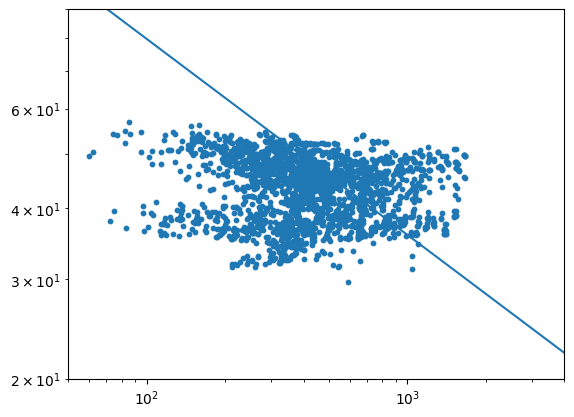

In [10]:
plt.scatter(pred_p, pred_s, s=10)

xs = [50, 4000]
ys = [30.967e6**(1/2.888)*x**(-1/2.888) for x in xs]
plt.plot(xs, ys, label='2008 Robeson')

plt.xscale('log')
plt.yscale('log')
plt.xlim(50, 4000)
plt.ylim(20, 90)